In [2]:
# note that tabular preprocessors require scikit-learn>=0.24.0
!pip install scikit-learn --upgrade 

% tensorflow_version 1.x

  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aimodelshare 0.0.95 requires scikit-learn==0.24.2, but you have scikit-learn 1.0.2 which is incompatible.
TensorFlow 1.x selected.


In [1]:
# Get competition data
! pip install aimodelshare --upgrade

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

np.random.seed(0)

In [4]:
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/world_happiness_competition_data-repository:latest')


Data downloaded successfully.


In [5]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
99,Libya,1.044,1.303,0.673,0.416,0.133,0.152,Libya,Africa,Northern Africa,1448.000000
100,Albania,0.947,0.848,0.874,0.383,0.178,0.027,Albania,Europe,Southern Europe,9.000000
101,United Kingdom,1.333,1.538,0.996,0.450,0.348,0.278,United Kingdom,Europe,Northern Europe,339.000000
102,China,1.029,1.125,0.893,0.521,0.058,0.100,China,Asia,Eastern Asia,37.000000


2.1 [15 pts] Explore bivariate results (Use visualizations!) -- Describe any relationships you see between particular features and the target variable


In [6]:
happiness_concat = pd.concat([X_train, y_train], axis = 1)
happiness_concat.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000,0,0,0,1,0
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000,0,0,1,0,0
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000,0,0,1,0,0
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111,0,1,0,0,0
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000,0,0,0,1,0


In [7]:
happiness_concat["Average"] = np.where(happiness_concat["Average"] == 1, 3, 0)
happiness_concat["High"] = np.where(happiness_concat["High"] == 1, 4, 0)
happiness_concat["Low"] = np.where(happiness_concat["Low"] == 1, 2, 0)
happiness_concat["Very High"] = np.where(happiness_concat["Very High"] == 1, 5, 0)
happiness_concat["Very Low"] = np.where(happiness_concat["Very Low"] == 1, 1, 0)

In [8]:
happiness_concat.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000,0,0,0,5,0
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000,0,0,2,0,0
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000,0,0,2,0,0
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111,0,4,0,0,0
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000,0,0,0,5,0


In [9]:
happiness_concat["num_happy"] = happiness_concat.iloc[:, 11:16].sum(axis=1)
happiness_concat

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low,num_happy
0,Saudi Arabia,1.403,1.357,0.795,0.439,0.080,0.132,Saudi Arabia,Asia,Western Asia,173.000000,0,0,0,5,0,5
1,Georgia,0.886,0.666,0.752,0.346,0.043,0.164,Georgia,Asia,Western Asia,18.000000,0,0,2,0,0,2
2,Guinea,0.380,0.829,0.375,0.332,0.207,0.086,Guinea,Africa,Sub-Saharan Africa,3.000000,0,0,2,0,0,2
3,Lithuania,1.238,1.515,0.818,0.291,0.043,0.042,Lithuania,Europe,Northern Europe,125.611111,0,4,0,0,0,4
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe,1.000000,0,0,0,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Libya,1.044,1.303,0.673,0.416,0.133,0.152,Libya,Africa,Northern Africa,1448.000000,3,0,0,0,0,3
100,Albania,0.947,0.848,0.874,0.383,0.178,0.027,Albania,Europe,Southern Europe,9.000000,0,0,2,0,0,2
101,United Kingdom,1.333,1.538,0.996,0.450,0.348,0.278,United Kingdom,Europe,Northern Europe,339.000000,0,0,0,5,0,5
102,China,1.029,1.125,0.893,0.521,0.058,0.100,China,Asia,Eastern Asia,37.000000,3,0,0,0,0,3


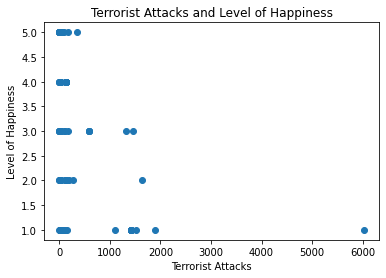

In [10]:
_ = plt.scatter(happiness_concat["Terrorist_attacks"], happiness_concat["num_happy"], marker='o')
plt.title("Terrorist Attacks and Level of Happiness")
plt.xlabel("Terrorist Attacks")
plt.ylabel("Level of Happiness")
plt.show()

We could learly see that there are a negative correlation between terrorist attacks and the level of happiness. As the terrorist attacks increase, the level of happiness decrease; as the terrorist attckas decrease, the level of happiness increase. 

2.2 Examine features that predict happiness categories using one or more models that allow for automatic feature selection. -- Explain any meaningful findings

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train)

In [12]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [13]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(104, 26)

In [18]:
X_train2 = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)

In [21]:
clf = LogisticRegression(multi_class='multinomial', penalty='l2', C=20).fit(X_train2, y_train_labels)
print("The training dataset has score: {:.2f}".format(clf.score(X_train2, y_train_labels)))

The training dataset has score: 0.62


In [22]:
pd.DataFrame(clf.coef_[0], 
             X_train2.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Healthy life expectancy,1.184998
GDP per capita,0.783528
Social support,0.073484
Terrorist_attacks,0.002048
Generosity,-1.001025
Perceptions of corruption,-1.242382
Freedom to make life choices,-1.283487


I found the healthy life expectancy, GDP per capita, and socail support  features are the most important three featuers to the happiness level.

 2.3 Run at least three prediction models to try to predict World Happiness well. -- Discuss which models performed better and point out relevant hyper-parameter values for successful models.

In [39]:
# Random Forest
hyperparameters = {'n_estimators': (30, 300, 1000), 'max_depth': (1, 3, 5, 10)}

random_forest = RandomForestClassifier()
forest_cv = GridSearchCV(random_forest, hyperparameters, cv = 10)
forest_cv.fit(preprocessor(X_train), y_train_labels)

print("Best Parameters {:.3f}:", forest_cv.best_params_)

Best Parameters {:.3f}: {'max_depth': 10, 'n_estimators': 300}


In [41]:
model_rf = RandomForestClassifier(n_estimators=300, max_depth=10)
model_rf.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_rf.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

1.0

In [68]:
# Penalized Logistic Regressopm
hyperparameters = {'C':np.logspace(1, 10, 100), 'penalty':['l2']}

logit = LogisticRegression()
logit_cv = GridSearchCV(logit, hyperparameters, cv = 10)
logit_cv.fit(preprocessor(X_train), y_train_labels)

print("Best Parameters {:.3f}:", logit_cv.best_params_)

Best Parameters {:.3f}: {'C': 10.0, 'penalty': 'l2'}


In [76]:
model_logit = LogisticRegression(C=10, penalty='l2', solver = "lbfgs")
model_logit.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_logit.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8557692307692307

In [71]:
# SVC
from sklearn.svm import SVC 
hyperparameters = {"C": [0.1,1, 10, 100], "gamma": [1,0.1,0.01,0.001]}

SVC = SVC()
svc_cv = GridSearchCV(SVC, hyperparameters, cv = 10)
svc_cv.fit(preprocessor(X_train), y_train_labels)

print("Best Parameters {:.3f}:", svc_cv.best_estimator_)

Best Parameters {:.3f}: SVC(C=1, gamma=0.1)


In [81]:
from sklearn.svm import SVC 

model_svc = SVC(C=1, gamma=0.1, kernel = "rbf")
model_svc.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_svc.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8173076923076923

My best model is the random forest. The best Parameters are max_depth: 10, n_estimators: 300. 

2.4 [10 pts] Submit your best model to the leader board for the World Happiness AI Model Share competition created for this class. Remember to use the instructions on the World Happiness Model Submission Guide notebook, including the specific code to load your train and tests sets.


In [42]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [46]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://c3maq947kb.execute-api.us-east-1.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [43]:
# Save random forest model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_rf, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [47]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [48]:
#Submit Model 1: Random forest 

#-- Generate predicted values (Model 1)
prediction_labels = model_rf.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 234

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [93]:
# Save svc model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_svc, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [94]:
#Submit Model 2: SVC 

#-- Generate predicted y values (Model 2)
prediction_labels = model_svc.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 190

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1289


In [89]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,inputlayer_layers,concatenate_layers,batchnormalization_layers,dropout_layers,dense_layers,softmax_act,sigmoid_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,63.46%,63.77%,68.22%,63.47%,keras,False,True,Sequential,6.000000,358405.000000,nan,nan,nan,nan,6.000000,1.000000,nan,3.000000,str,SGD,"{'name': 'sequential_344', 'la...",1280568.000000,melissa_feeney,163
1,57.69%,57.34%,64.50%,57.62%,keras,False,True,Sequential,6.000000,358405.000000,nan,nan,nan,nan,6.000000,1.000000,nan,3.000000,str,SGD,"{'name': 'sequential_343', 'la...",1280568.000000,melissa_feeney,162
2,57.69%,56.65%,62.32%,57.65%,sklearn,False,False,BaggingClassifier,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"{'base_estimator': None, 'boot...",nan,jw3995,188
3,57.69%,56.85%,61.48%,58.36%,keras,False,True,Sequential,5.000000,18117.000000,nan,nan,nan,nan,5.000000,1.000000,nan,4.000000,str,SGD,"{'name': 'sequential', 'layers...",1461312.000000,yl4590,18
4,55.77%,54.90%,62.86%,55.15%,sklearn,False,False,BaggingClassifier,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"{'base_estimator': None, 'boot...",nan,jw3995,183
6,55.77%,56.27%,60.98%,56.17%,keras,False,True,Sequential,6.000000,358405.000000,nan,nan,nan,nan,6.000000,1.000000,nan,3.000000,str,SGD,"{'name': 'sequential_342', 'la...",1280568.000000,melissa_feeney,161
7,55.77%,55.97%,60.95%,56.35%,keras,False,True,Sequential,6.000000,358405.000000,nan,nan,nan,nan,6.000000,1.000000,nan,2.000000,str,SGD,"{'name': 'sequential_7', 'laye...",1263864.000000,melissa_feeney,115
8,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,97
9,53.85%,52.62%,63.74%,56.71%,sklearn,False,False,KNeighborsClassifier,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"{'algorithm': 'auto', 'leaf_si...",nan,wxmkevin,74
10,55.77%,55.90%,59.92%,56.32%,sklearn,False,False,RandomForestClassifier,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"{'bootstrap': True, 'ccp_alpha...",nan,shm2166,99
